In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2023-04-27 11:17:54.050149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
POS_PATH = os.path.join('faces', 'positive')
NEG_PATH = os.path.join('faces', 'negative')
ANC_PATH = os.path.join('faces', 'anchor')

In [4]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'faces/positive'

In [5]:
!tar -xf lfw.tgz

In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:
for face in os.listdir(POS_PATH):
    print(face)

In [8]:
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'faces/anchor/dca75004-e4e4-11ed-b458-3af9d33afe73.jpg'

In [84]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    import time

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        time.sleep(0.5)  # introduce a small delay
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [24]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [25]:
dir_test = anchor.as_numpy_iterator()

In [26]:
print(dir_test.next())


b'faces/anchor/0d7c9e4a-e4e6-11ed-b458-3af9d33afe73.jpg'


In [27]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [28]:
img = preprocess('faces/anchor/0d7c9e4a-e4e6-11ed-b458-3af9d33afe73.jpg')

In [31]:
img.numpy().max()

0.9992647

In [32]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [33]:
samples = data.as_numpy_iterator()

In [37]:
example = samples.next()

In [38]:
example

(b'faces/anchor/30a86782-e4e6-11ed-b458-3af9d33afe73.jpg',
 b'faces/positive/31706f84-e4e6-11ed-b458-3af9d33afe73.jpg',
 1.0)

In [39]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [41]:
res = preprocess_twin(*exampple)

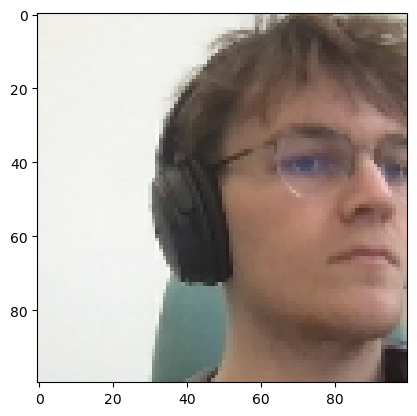

In [42]:
plt.imshow(res[1])

In [43]:
res[2]


1.0

In [44]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [45]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [46]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [47]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [48]:
embedding = make_embedding()

In [49]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [50]:
l1 = L1Dist()

In [53]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [54]:
siamese_model = make_siamese_model()

In [56]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [57]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [58]:
opt = tf.keras.optimizers.Adam(1e-4)

In [59]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [60]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [61]:
from tensorflow.keras.metrics import Precision, Recall

In [62]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [63]:
EPOCHS = 50

In [64]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 11s 4s/step
0.6784606 0.0 0.0

 Epoch 2/50
2/2 [==============================] - 9s 4s/step
0.5845203 0.0 0.0

 Epoch 3/50
2/2 [==============================] - 10s 4s/step
0.45861468 0.0 0.0

 Epoch 4/50
2/2 [==============================] - 10s 4s/step
0.36254892 0.0 0.0

 Epoch 5/50
2/2 [==============================] - 10s 4s/step
0.1450378 0.0 0.0

 Epoch 6/50
2/2 [==============================] - 14s 7s/step
0.0661388 0.2 1.0

 Epoch 7/50
2/2 [==============================] - 11s 4s/step
0.06314746 0.0 0.0

 Epoch 8/50
2/2 [==============================] - 10s 4s/step
0.22871393 0.25 1.0

 Epoch 9/50
2/2 [==============================] - 10s 4s/step
0.17505407 0.8 1.0

 Epoch 10/50
2/2 [==============================] - 10s 4s/step
0.124844015 0.0 0.0

 Epoch 11/50
2/2 

2/2 [==============================] - 10s 4s/step
7.602617e-05 1.0 1.0

 Epoch 43/50
2/2 [==============================] - 10s 4s/step
6.0289054e-05 1.0 1.0

 Epoch 44/50
2/2 [==============================] - 10s 4s/step
5.9953036e-06 1.0 1.0

 Epoch 45/50
2/2 [==============================] - 10s 4s/step
5.7407215e-05 1.0 1.0

 Epoch 46/50
2/2 [==============================] - 10s 4s/step
5.711276e-05 1.0 1.0

 Epoch 47/50
2/2 [==============================] - 10s 4s/step
1.3495806e-05 1.0 1.0

 Epoch 48/50
2/2 [==============================] - 10s 4s/step
6.973854e-06 1.0 1.0

 Epoch 49/50
2/2 [==============================] - 10s 4s/step
1.1687799e-05 1.0 1.0

 Epoch 50/50
2/2 [==============================] - 10s 4s/step
7.6246506e-06 1.0 1.0


In [65]:
from tensorflow.keras.metrics import Precision, Recall

In [66]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [67]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 470ms/step


In [68]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]

In [69]:
y_true

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [70]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [71]:
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [76]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 504ms/step
1.0 1.0


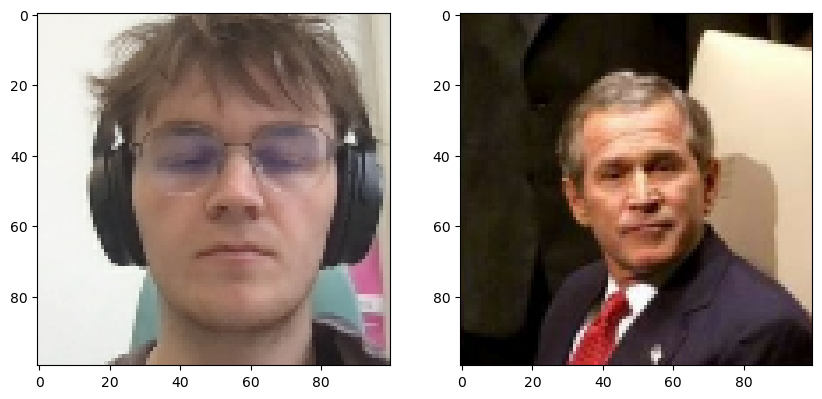

In [77]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [78]:
siamese_model.save('siamesemodelv2.h5')

In [79]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [80]:
siamese_model.predict([test_input, test_val])


1/1 [==============================] - 1s 540ms/step


array([[1.3611959e-10],
       [9.9993008e-01],
       [1.0212946e-05],
       [1.1357152e-05],
       [1.0643200e-07],
       [3.5071068e-11],
       [2.6443404e-06],
       [9.9871945e-01],
       [2.1724689e-05],
       [1.0576021e-10],
       [2.1488304e-06],
       [6.2894557e-08]], dtype=float32)

In [81]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [85]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [98]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 145ms/step
False
1/1 [==============================] - 0s 140ms/step
False
1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 147ms/step
False
1/1 [==============================] - 0s 140ms/step
False
1/1 [==============================] - 0s 140ms/step
False
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 141ms/step
False
1/1 [==============================] - 0s 142ms/step
False
1/1 [==============================] - 0s 140ms/step
False
1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 146ms/step
False
1/1 [==============================] - 0s 137ms/step
False


In [93]:
results

[array([[0.8260997]], dtype=float32),
 array([[0.23988397]], dtype=float32),
 array([[0.01918999]], dtype=float32),
 array([[0.9319823]], dtype=float32),
 array([[0.01702019]], dtype=float32),
 array([[0.9835673]], dtype=float32),
 array([[0.9076026]], dtype=float32),
 array([[0.95758677]], dtype=float32),
 array([[0.20752732]], dtype=float32),
 array([[0.9517281]], dtype=float32),
 array([[0.99593246]], dtype=float32),
 array([[0.23703976]], dtype=float32),
 array([[0.99785924]], dtype=float32),
 array([[0.7509084]], dtype=float32),
 array([[0.10695233]], dtype=float32),
 array([[0.26296744]], dtype=float32),
 array([[0.0004991]], dtype=float32),
 array([[0.7967934]], dtype=float32),
 array([[0.20533615]], dtype=float32),
 array([[0.08883853]], dtype=float32),
 array([[0.9691604]], dtype=float32),
 array([[0.9993899]], dtype=float32),
 array([[0.99199593]], dtype=float32),
 array([[0.27395114]], dtype=float32),
 array([[0.22095726]], dtype=float32),
 array([[0.2946351]], dtype=float32

In [97]:
np.sum(np.squeeze(results) > 0.5)

29